## Customer Model Behavior Analysis
---

* customer model behavior
    * [force plot](https://docs.google.com/document/d/1_xQoyimEkDi-Guoml2MxS6wXQATmy8D27iSsQ4LIAzY/edit) for missing fraud_score_1
    * [detailed feature importance](https://docs.google.com/spreadsheets/d/1YZEXwaCuxTTXL5skdSz_ZdIZujr2kUhQaK076Sy4KK4/edit#gid=0)
    
  OOT samples in 2021 from dropping fraud_score_1 entirely and changing missing name_address_correlation to 1
  
* may need to look at the feature behavior over the years.

In [1]:
import sys, os, json
sys.path.append('../..')
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from tqdm import tqdm
import copy

from smart_open import open
import pickle as pkl
import src.monitoring.utils as mu

from src.utils import scale_scores
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

plt.style.use("seaborn")

In [2]:
# load models

with open("../../config.json", "r") as f:
    config = json.load(f)
    mpaths = config["monitoring_config"]["model_paths"]
    
with open(mpaths["incumbent_model"], "rb") as f:
    incumbent_model = pkl.load(f)
    
with open(mpaths["customer_refitted_2021Q1"], "rb") as f:
    refitted_model = pkl.load(f)

In [3]:
# # load prod data
# output_path = f"s3://sofi-data-science/jxu/data_dump/money-analysis/prod-2021-08-02.parquet"
# df = pd.read_parquet(output_path)

# # clean data
# for col in ["created_dt", "updated_dt", "last_checked_date", "last_checked_date_max"]:
#     df[col] = pd.to_datetime(df[col])

In [4]:
mconfig = config["monitoring_config"]
locals().update(mconfig)   # this would set k-v pairs in mconfig as local variables
print(mconfig.keys())

# load dev side data
static_sample_dates = [pd.to_datetime(d) for d in monitoring_dates]
date_sample_end = pd.to_datetime(date_sample_end)

df = pd.read_feather(dev_df_path)
test_df = df[df.is_static 
             & (df.sample_date.isin(monitoring_dates))]

dict_keys(['mmonth', 'dev_df_path', 'monitoring_dates', 'prod_data_dates', 'data_output_path', 'artifact_path', 'date_sample_start', 'date_sample_end', 'model_paths', 'prev_test_df_path', 'modeling_df_path', 'test_df_path', 'prod_dfs_path'])


In [5]:
df = test_df[test_df.sample_date == pd.to_datetime("2021-06-01")].copy()

In [6]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])

In [7]:
# other setups
features = incumbent_model.feature_name_

df = mu.prep_customer_data(df)

df["pred_incumbent"] = incumbent_model.predict_proba(df[features])[:,1]
df["pred_refitted"] = refitted_model.predict_proba(df[features])[:,1]

df["score_incumbent"] = mu.scale_scores(df["pred_incumbent"])
df["score_refitted"] = mu.scale_scores(df["pred_refitted"])

In [8]:
df.head()

,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_amount,external_account_number,real_ending_balance,user_id,sofi_employee_ind,dtc,...,all7120_default_encoded,bcc7120_default_encoded,party_id,is_active,fico_adjusted,fico_adjusted_pred,pred_incumbent,pred_refitted,score_incumbent,score_refitted
10606129,NaT,141546.0,410000096715,None,NaN,None,NaN,855,False,None,...,-1.0,-1.0,855,False,NaN,NaN,0.237114,0.438784,595.939068,624.362640
10606130,2021-05-31 00:05:26,5618.0,410011698790,IIPD,0.00,,228.63,257,False,None,...,-1.0,-1.0,257,False,768.0,-768.0,0.022277,0.020835,515.423090,513.315192
10606131,2021-05-30 07:00:48,90.0,410001537288,DWTRF,-0.33,,283491.89,273,False,None,...,-1.0,-1.0,273,True,767.0,-767.0,0.000696,0.000370,407.960761,388.465583
10606132,2020-04-28 04:46:22,103.0,410002729647,ACHDWIN,-0.65,,1106.44,299,False,None,...,-1.0,-1.0,299,False,799.0,-799.0,0.000493,0.008410,397.307481,484.972425
10606133,NaT,107.0,410000276182,None,NaN,None,NaN,305,False,None,...,-1.0,-1.0,305,False,NaN,NaN,0.133862,0.357837,574.411334,613.927501


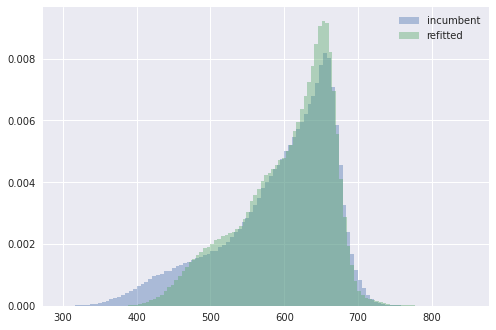

In [9]:
df.score_incumbent.hist(bins=100, alpha=0.4, density=True, label="incumbent")
df.score_refitted.hist(bins=100, alpha=0.4, density=True, label="refitted")
plt.legend()

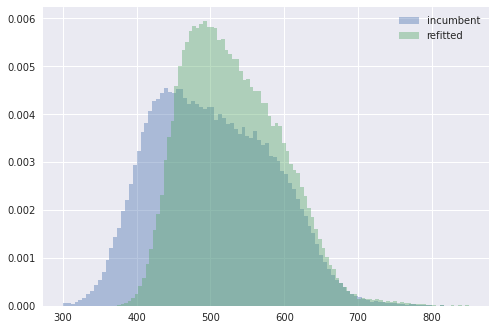

In [10]:
df[df.is_active].score_incumbent.hist(bins=100, alpha=0.4, density=True, label="incumbent")
df[df.is_active].score_refitted.hist(bins=100, alpha=0.4, density=True, label="refitted")
plt.legend()

#### name_address_corr behavior

(<AxesSubplot:>, (906196, 102))

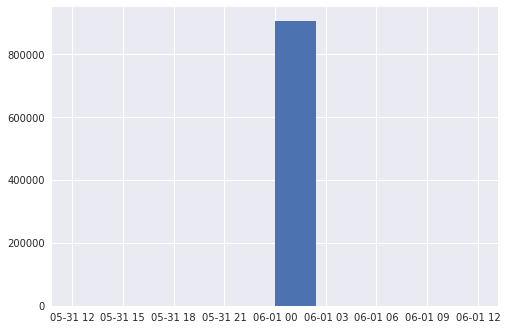

In [11]:
df.sample_date.hist(), df.shape

In [12]:
df.name_address_correlation.isna().value_counts()

False    904236
True       1960
Name: name_address_correlation, dtype: int64

In [13]:
df["missing_nac"] = df.name_address_correlation.isna()
df[["missing_nac", "is_active"]].value_counts()

missing_nac  is_active
False        False        776532
             True         127704
True         False          1934
             True             26
dtype: int64

In [14]:
test_df

,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_amount,external_account_number,real_ending_balance,user_id,sofi_employee_ind,dtc,...,last_unrestricted_date_in_next_90d,latest_acc_bal,is_chg_wrt_off_in_90d,nr_returns_in_next_90d,bal_after_90d,target,indeterminate,sample_date,is_static,nr_transactions_next_60d
5056065,2020-12-31 00:06:26,135.0,410000345005,DDINT,0.01,,1180.72,361,False,None,...,False,2288.82,False,0.0,3193.06,False,False,2021-01-01,True,71.0
5056066,NaT,107.0,410000276182,None,NaN,None,NaN,305,False,None,...,False,NaN,False,0.0,NaN,False,True,2021-01-01,True,0.0
5056067,2020-12-22 19:40:04,149.0,410000091385,DDATMREFUND,2.60,,30.00,402,False,2021-01-03,...,False,0.00,False,0.0,0.00,False,False,2021-01-01,True,1.0
5056068,2020-12-18 07:14:46,180.0,410000096214,ACHDDIN,12.90,,2239.71,493,False,None,...,True,2366.38,False,0.0,2366.38,False,False,2021-01-01,True,1.0
5056069,NaT,355784.0,410000191510,None,NaN,None,NaN,743,False,None,...,False,NaN,False,0.0,NaN,False,True,2021-01-01,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11512320,NaT,12750358.0,410015492339,None,NaN,None,NaN,18928075,False,None,...,False,NaN,False,0.0,NaN,False,True,2021-06-01,True,0.0
11512321,NaT,12750032.0,410015491888,None,NaN,None,NaN,18927916,False,None,...,False,1490.00,False,0.0,1490.00,False,True,2021-06-01,True,5.0
11512322,NaT,12750023.0,410015491842,None,NaN,None,NaN,18927907,False,None,...,False,NaN,False,0.0,NaN,False,True,2021-06-01,True,0.0
11512323,NaT,12750312.0,410015492171,None,NaN,None,NaN,18928027,False,None,...,False,NaN,False,0.0,NaN,False,True,2021-06-01,True,0.0


In [15]:
import rdsutils.plot as rdsplot

In [41]:
full_df = pd.read_feather(dev_df_path)
full_df = full_df[(full_df.is_static) & 
                  (full_df.sample_date < pd.to_datetime("2021-01-01"))
                  | (full_df.sample_date.isin(static_sample_dates))].drop_duplicates()

<AxesSubplot:>

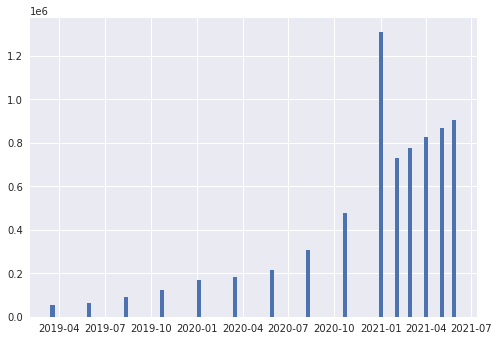

In [42]:
full_df.sample_date.hist(bins=100)

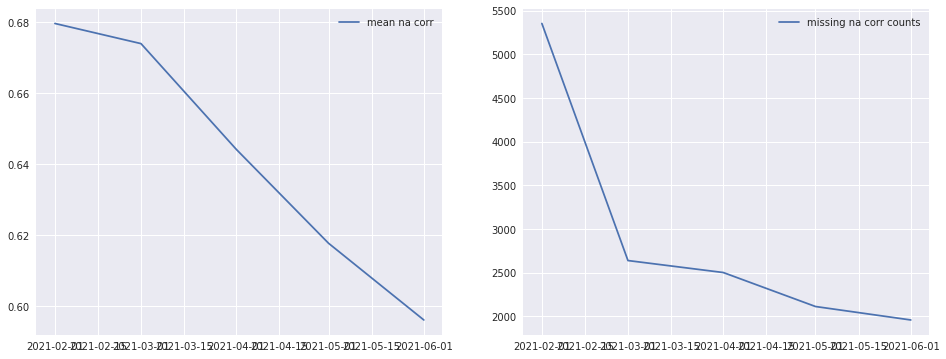

In [80]:
df_ = full_df[(~full_df.missing_nac) & (full_df.sample_date > pd.to_datetime("2021-01-01"))]
nac_trend = df_.groupby("sample_date")["name_address_correlation"].agg(["mean", "std", "median"]).sort_index()
nac_trend["lower"] = nac_trend["mean"] - nac_trend["std"]
nac_trend["upper"] = nac_trend["mean"] + nac_trend["std"]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(nac_trend.index, nac_trend[["mean"]].values, label="mean na corr")
# axs[0].plot(nac_trend.index, nac_trend[["median"]].values, label="median na corr")
axs[0].legend()

full_df["missing_nac"] = full_df["name_address_correlation"].isna()
df_ = full_df[(full_df.sample_date > pd.to_datetime("2021-01-01"))]
missing_nac_count = df_.groupby("sample_date")["missing_nac"].sum().sort_index()

axs[1].plot(missing_nac_count.index, 
            missing_nac_count.values,
            label="missing na corr counts")
axs[1].legend()

plt.show()

### name_address_corr
---

* missing name_address_corr is good in our case.
    * for no address data, it just means we validated address with Experian so that's actually good

In [ ]:
# # V1: only take the already missing population

# # take subset with available na corr
# cond = (df.name_address_correlation.isna())
# df_wo_nac = df[cond]

# # MISSING FRAUD_SCORE_1
# # now create a copy of df_w_fs1 and map over the fraud score 1
# df_w_nac = df_wo_nac.copy()
# df_w_nac.name_address_correlation = 0.99

# # re score df_wo_fs1
# df_w_nac["pred_incumbent"] = incumbent_model.predict_proba(df_w_nac[features])[:,1]
# df_w_nac["pred_refitted"] = refitted_model.predict_proba(df_w_nac[features])[:,1]

# df_w_nac["score_incumbent"] = mu.scale_scores(df_w_nac["pred_incumbent"])
# df_w_nac["score_refitted"] = mu.scale_scores(df_w_nac["pred_refitted"])

# display(df_w_nac.shape, df_wo_nac.shape)

In [66]:
# v2: mask out all, and re impute?

# take subset with available na corr
# cond = df.name_address_correlation > 0.5
# df_wo_nac = df[cond].copy()

df_wo_nac = df.copy()
df_wo_nac.name_address_correlation = np.nan

# MISSING FRAUD_SCORE_1
# now create a copy of df_w_fs1 and map over the fraud score 1
df_w_nac = df_wo_nac.copy()
df_w_nac.name_address_correlation = 0.99

# re score df_wo_fs1
df_w_nac["pred_incumbent"] = incumbent_model.predict_proba(df_w_nac[features])[:,1]
df_w_nac["pred_refitted"] = refitted_model.predict_proba(df_w_nac[features])[:,1]

df_w_nac["score_incumbent"] = mu.scale_scores(df_w_nac["pred_incumbent"])
df_w_nac["score_refitted"] = mu.scale_scores(df_w_nac["pred_refitted"])

# display(df_w_nac.shape, df_wo_nac.shape)

In [67]:
display(df_w_nac[df_w_nac.name_address_correlation>0.9].head())
display(df_wo_nac[df_wo_nac.name_address_correlation>0.9].head())

,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_amount,external_account_number,real_ending_balance,user_id,sofi_employee_ind,dtc,...,bcc7120_default_encoded,party_id,is_active,fico_adjusted,fico_adjusted_pred,pred_incumbent,pred_refitted,score_incumbent,score_refitted,missing_nac
10606129,NaT,141546.0,410000096715,None,NaN,None,NaN,855,False,None,...,-1.0,855,False,NaN,NaN,0.217557,0.492592,592.506735,631.032406,False
10606130,2021-05-31 00:05:26,5618.0,410011698790,IIPD,0.00,,228.63,257,False,None,...,-1.0,257,False,768.0,-768.0,0.023163,0.031195,516.651862,526.079626,False
10606131,2021-05-30 07:00:48,90.0,410001537288,DWTRF,-0.33,,283491.89,273,False,None,...,-1.0,273,True,767.0,-767.0,0.000925,0.000382,416.717825,389.459780,False
10606132,2020-04-28 04:46:22,103.0,410002729647,ACHDWIN,-0.65,,1106.44,299,False,None,...,-1.0,299,False,799.0,-799.0,0.000631,0.008983,404.918892,487.020663,False
10606133,NaT,107.0,410000276182,None,NaN,None,NaN,305,False,None,...,-1.0,305,False,NaN,NaN,0.128079,0.359007,572.845547,614.084270,False


,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_amount,external_account_number,real_ending_balance,user_id,sofi_employee_ind,dtc,...,bcc7120_default_encoded,party_id,is_active,fico_adjusted,fico_adjusted_pred,pred_incumbent,pred_refitted,score_incumbent,score_refitted,missing_nac


In [68]:
# i = 10608405
# df_exp = pd.concat([df_w_nac.loc[i][features+["score_incumbent", "score_refitted"]].to_frame(), 
#            df_wo_nac.loc[i][features+["score_incumbent", "score_refitted"]].to_frame()],
#           axis=1).T
# df_exp[["name_address_correlation", "score_incumbent", "score_refitted"]]  # fraud_score_1: 0.0266-> nan; no change

In [69]:
def plot_difference(expected_sequence, actual_sequence, 
                    figsize=(9,7), bins=10, label='exp - actual', title=''):
    """ Plot the distr of difference of two sequences 
    Two sequences should have the same size
    """
    assert(len(expected_sequence) == len(actual_sequence))
    fig = plt.figure(figsize=figsize)
    seq = np.array(expected_sequence) - np.array(actual_sequence)
    plt.hist(seq, alpha=0.6, bins=bins, label=label)
    plt.legend()
    plt.title(title)
    return fig

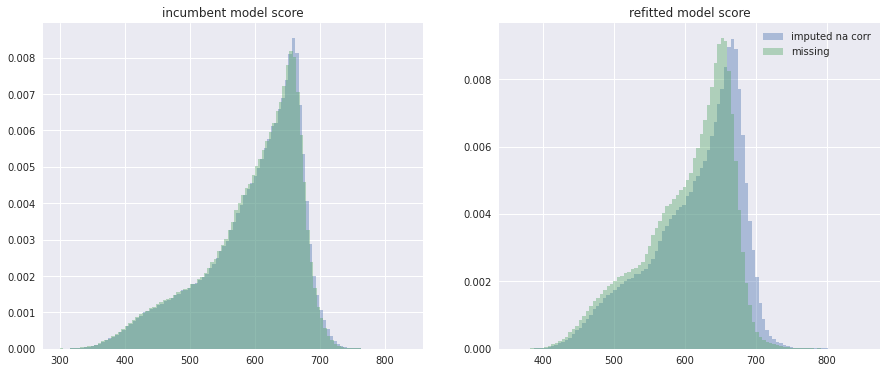

In [70]:
score_col = "score_incumbent"
fig, axs = plt.subplots(1,2,figsize=(15,6))

df_w_nac[score_col].hist(bins=100, alpha=0.4, ax=axs[0],
                         density=True, label="imputed na corr")
df_wo_nac[score_col].hist(bins=100, alpha=0.4, ax=axs[0],
                          density=True, label="missing")
axs[0].set_title("incumbent model score")

score_col = "score_refitted"
df_w_nac[score_col].hist(bins=100, alpha=0.4, ax=axs[1],
                         density=True, label="imputed na corr")
df_wo_nac[score_col].hist(bins=100, alpha=0.4, ax=axs[1],
                          density=True, label="missing")
axs[1].set_title("refitted model score")

plt.legend()
plt.show()

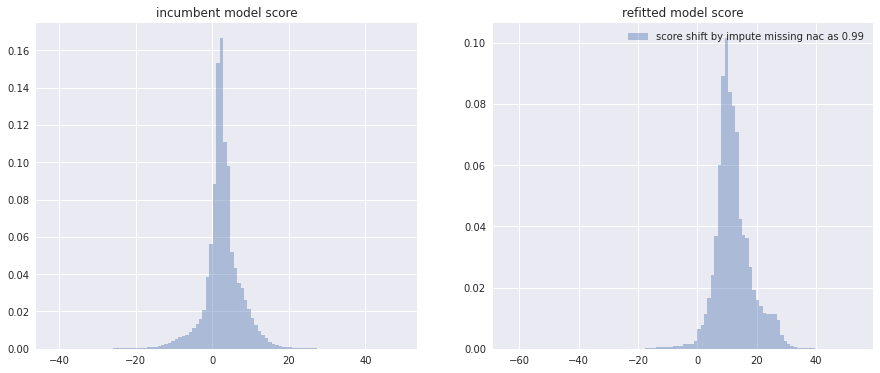

In [71]:
score_col = "score_incumbent"
fig, axs = plt.subplots(1,2,figsize=(15,6))

score_diff = df_w_nac[score_col] - df_wo_nac[score_col] 
score_diff.hist(bins=100, alpha=0.4, ax=axs[0],
                         density=True, label="score shift by impute missing nac as 0.99")
axs[0].set_title("incumbent model score")

score_col = "score_refitted"
score_diff = df_w_nac[score_col] - df_wo_nac[score_col]
score_diff.hist(bins=100, alpha=0.4, ax=axs[1],
                         density=True, label="score shift by impute missing nac as 0.99")
axs[1].set_title("refitted model score")

plt.legend()
plt.show()

#### the incumbent model penalize missing fraud_score_1 more

What is the cause?
* is the information included in fraud score 2?
    * let's mask fs2 also and take a look
* how about the active user segment?

#### Active population

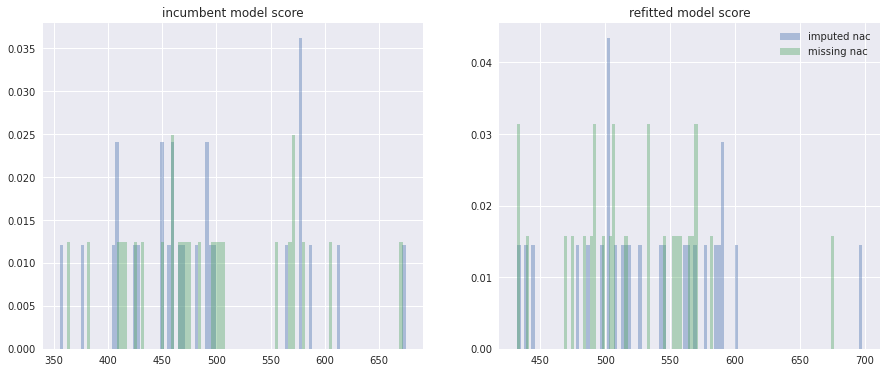

In [60]:
score_col = "score_incumbent"
fig, axs = plt.subplots(1,2,figsize=(15,6))
df_w_nac_ = df_w_nac[df_w_nac.is_active]
df_wo_nac_ = df_wo_nac[df_wo_nac.is_active]

df_w_nac_[score_col].hist(bins=100, alpha=0.4, ax=axs[0],
                         density=True, label="imputed nac")
df_wo_nac_[score_col].hist(bins=100, alpha=0.4, ax=axs[0],
                          density=True, label="missing nac")
axs[0].set_title("incumbent model score")

score_col = "score_refitted"
df_w_nac_[score_col].hist(bins=100, alpha=0.4, ax=axs[1],
                         density=True, label="imputed nac")
df_wo_nac_[score_col].hist(bins=100, alpha=0.4, ax=axs[1],
                          density=True, label="missing nac")
axs[1].set_title("refitted model score")

plt.legend()
plt.show()

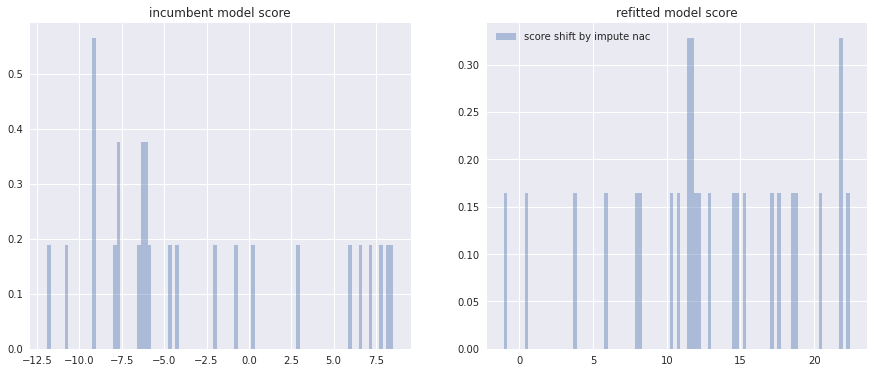

In [61]:
score_col = "score_incumbent"
fig, axs = plt.subplots(1,2,figsize=(15,6))
df_w_nac_ = df_w_nac[df_w_nac.is_active]
df_wo_nac_ = df_wo_nac[df_wo_nac.is_active]

score_diff = df_w_nac_[score_col] - df_wo_nac_[score_col] 
score_diff.hist(bins=100, alpha=0.4, ax=axs[0],
                         density=True, label="score shift by impute nac")
axs[0].set_title("incumbent model score")

score_col = "score_refitted"
score_diff = df_w_nac_[score_col] - df_wo_nac_[score_col]
score_diff.hist(bins=100, alpha=0.4, ax=axs[1],
                         density=True, label="score shift by impute nac")
axs[1].set_title("refitted model score")

plt.legend()
plt.show()